# Introduction

We will create a dataset with customers.  
We first cluster them using K-Means and then we will create a model for churn prediction.


# Data synthesis

In [57]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_customers = 4000

# data, with some level of noise
data = pd.DataFrame({
    "age": np.random.randint(18, 70, n_customers),
    "monthly_spend": np.random.normal(120, 50, n_customers),
    "tenure_months": np.random.randint(1, 72, n_customers),
    "num_logins": np.random.poisson(20, n_customers),
    "support_tickets": np.random.poisson(3, n_customers),
    "random_noise": np.random.normal(0, 1, n_customers),
})


# Simulate churn, add some noise
from scipy.special import expit  # Sigmoid

# Linear combination with noise
logit = (
    -0.04 * data["tenure_months"] +
    -0.01 * data["monthly_spend"] +
    0.15 * data["support_tickets"] +
    0.02 * data["age"] +
    np.random.normal(0, 0.01, n_customers)   # add noise
)

probability = expit(logit)

data["churn"] = np.random.binomial(1, probability)


In [47]:
data.head()

,age,monthly_spend,tenure_months,num_logins,support_tickets,random_noise,churn
0,56,136.339945,71,21,3,0.059937,0
1,69,201.450480,33,18,3,-0.129132,0
2,46,128.067896,31,20,2,0.194318,0
3,32,100.260122,55,22,2,-0.027488,0
4,60,93.822781,12,25,1,-0.027920,0


# Customer segmentation


## Data standardization

In [58]:
from sklearn.preprocessing import StandardScaler

features = data.drop(columns=["churn"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Clustering with K-Means

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
data["segment"] = kmeans.fit_predict(scaled_features)

## Visualize with PCA

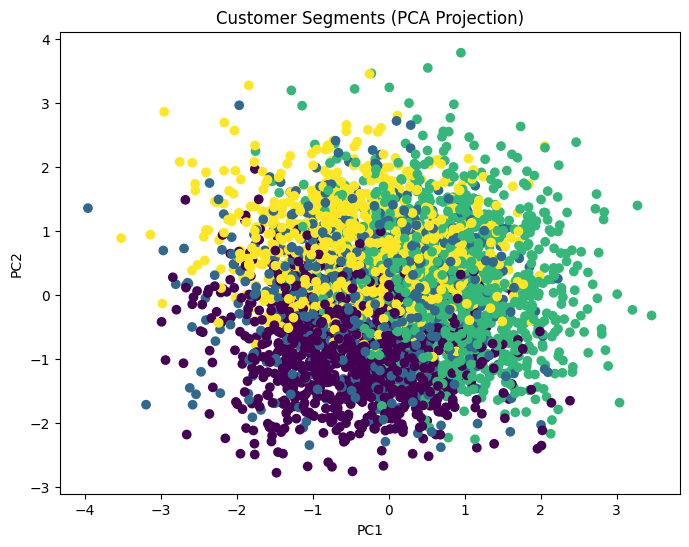

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=data["segment"], cmap='viridis')
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Churn Prediction

## Train/test split

In [61]:
from sklearn.model_selection import train_test_split

X = scaled_features
y = data["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Train Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

## Predict probabilities

In [63]:
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

In [64]:
features

,age,monthly_spend,tenure_months,num_logins,support_tickets,random_noise
0,56,136.339945,71,21,3,0.599368
1,69,201.450480,33,18,3,-1.291321
2,46,128.067896,31,20,2,1.943180
3,32,100.260122,55,22,2,-0.274879
4,60,93.822781,12,25,1,-0.279197
...,...,...,...,...,...,...
3995,28,132.350730,11,14,3,1.142983
3996,62,182.866733,16,24,1,-0.657425
3997,64,134.395741,19,17,3,0.419990
3998,29,123.942590,31,20,3,0.477962


## Evaluation using ROC-AUC

ROC-AUC: 0.7382624999999999
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       600
           1       0.55      0.27      0.36       200

    accuracy                           0.76       800
   macro avg       0.67      0.60      0.61       800
weighted avg       0.73      0.76      0.73       800



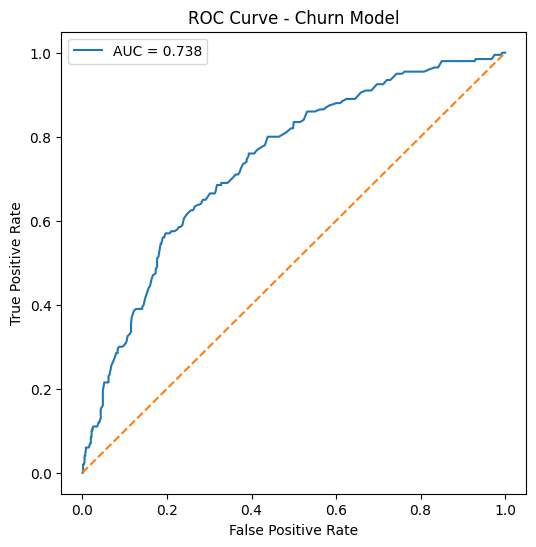

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Churn Model")
plt.legend()
plt.show()